In [7]:
"""
XGBoost Stroke Detection with Lagging Features
Creates temporal features by adding lagged keypoints from previous frames
"""

import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [8]:
CONFIG = {
    "data": {
        "lag_frames": 8,  # Number of previous frames to include as features
        "json_files": [
            "annotated_jsons/AO_Output.json",
            "annotated_jsons/FA Output.json",
            "annotated_jsons/video_4_annotated.json",
            "annotated_jsons/integrated_data.json",
            "annotated_jsons/nadines_video_annotated.json",
            "annotated_jsons/video_1_annotated.json",
        ],
    },
    "modeling": {
        "test_video_index": 3,  # Which video to hold out for testing (1-6)
        "model_type": "xgboost",  # "xgboost" or "random_forest"
        "model_path": "models/stroke_xgb_model.joblib",
        "balance_classes": True,
        "random_seed": 42,
    },
    "keypoints": {
        "relevant_names": [
            "left_shoulder",
            "right_shoulder",
            "left_elbow",
            "right_elbow",
            "left_wrist",
            "right_wrist",
            "left_hip",
            "right_hip",
            "left_knee",
            "right_knee",
            "left_ankle",
            "right_ankle",
        ],
    },
}

In [9]:
class DataProcessor:
    """Handles loading and preprocessing of stroke detection data."""

    def __init__(self):
        self.keypoint_names = CONFIG["keypoints"]["relevant_names"]

    def load_json_file(self, filepath, video_index):
        """Load and preprocess a single JSON file."""
        print(f"\nProcessing video {video_index}: {filepath}")

        # Load JSON
        df = pd.read_json(filepath)
        df["video_index"] = video_index

        # Expand keypoints
        df = self.expand_keypoints(df)

        # Normalize keypoints
        df = self.normalize_keypoints(df)

        # Add sequence labels (expand annotations ±7 frames)
        df = self.add_sequence_labels(df)

        # Drop unnecessary columns
        cols_to_drop = (
            ["player_id", "time", "index"]
            if "index" in df.columns
            else ["player_id", "time"]
        )
        df.drop(
            columns=[col for col in cols_to_drop if col in df.columns],
            inplace=True,
            errors="ignore",
        )

        print(f"  Frames: {len(df)}")
        print(f"  Event distribution: {df['event'].value_counts().to_dict()}")

        return df

    def expand_keypoints(self, df):
        """Expand nested keypoint dictionary into separate columns."""
        expanded_df = (
            df["keypoints"]
            .apply(
                lambda person: {f"x_{part}": person[part]["x"] for part in person}
                | {f"y_{part}": person[part]["y"] for part in person}
            )
            .apply(pd.Series)
        )

        df_expanded = pd.concat([df, expanded_df], axis=1)
        df_expanded.drop(columns=["keypoints"], inplace=True)

        return df_expanded

    def normalize_keypoints(self, df):
        """Normalize keypoints relative to hip center and torso length."""
        df_norm = df.copy()

        for idx, row in df.iterrows():
            # Calculate hip center
            hip_center_x = (row["x_left_hip"] + row["x_right_hip"]) / 2
            hip_center_y = (row["y_left_hip"] + row["y_right_hip"]) / 2

            # Calculate shoulder center
            shoulder_center_x = (row["x_left_shoulder"] + row["x_right_shoulder"]) / 2
            shoulder_center_y = (row["y_left_shoulder"] + row["y_right_shoulder"]) / 2

            # Calculate torso length
            torso_length = np.sqrt(
                (shoulder_center_x - hip_center_x) ** 2
                + (shoulder_center_y - hip_center_y) ** 2
            )

            if torso_length < 1e-6:
                torso_length = 1.0

            # Normalize all keypoints
            for name in self.keypoint_names:
                df_norm.at[idx, f"x_{name}"] = (
                    row[f"x_{name}"] - hip_center_x
                ) / torso_length
                df_norm.at[idx, f"y_{name}"] = (
                    row[f"y_{name}"] - hip_center_y
                ) / torso_length

        return df_norm

    def add_sequence_labels(self, df):
        """Add sequence labels by expanding annotations ±7 frames."""
        # Store original index
        df["orig_index"] = df.index

        event_indices = df[df["event"].notnull()].index

        selected_indices = set()
        neither_count = 0
        MAX_NEITHER_SEGMENTS = 100

        # Expand stroke annotations ±7 frames
        for idx in event_indices:
            label = df.at[idx, "event"]
            video_idx = df.at[idx, "video_index"]

            selected_indices.add(idx)
            df.at[idx, "event"] = label

            # Add 14 frames BEFORE
            for offset in range(1, 15):
                prev_idx = idx - offset
                if prev_idx < 0:
                    break
                if (
                    pd.notnull(df.at[prev_idx, "event"])
                    or df.at[prev_idx, "video_index"] != video_idx
                ):
                    break
                selected_indices.add(prev_idx)
                df.at[prev_idx, "event"] = label

            # # Add 7 frames AFTER
            # for offset in range(1, 8):
            #     next_idx = idx + offset
            #     if next_idx >= len(df):
            #         break
            #     if pd.notnull(df.at[next_idx, "event"]) or df.at[next_idx, "video_index"] != video_idx:
            #         break
            #     selected_indices.add(next_idx)
            #     df.at[next_idx, "event"] = label

        # Add "neither" segments (15-frame batches)
        null_indices = df[df["event"].isnull()].index
        null_indices = sorted(null_indices)

        i = 0
        while i < len(null_indices):
            if neither_count >= MAX_NEITHER_SEGMENTS:
                break

            start_idx = null_indices[i]
            video_idx = df.at[start_idx, "video_index"]

            segment = [start_idx]
            for j in range(i + 1, len(null_indices)):
                current_idx = null_indices[j]
                prev_idx = null_indices[j - 1]
                if (
                    current_idx == prev_idx + 1
                    and df.at[current_idx, "video_index"] == video_idx
                ):
                    segment.append(current_idx)
                else:
                    break

            for k in range(0, len(segment), 15):
                if neither_count >= MAX_NEITHER_SEGMENTS:
                    break
                batch = segment[k : k + 15]
                if len(batch) == 15:
                    for idx in batch:
                        selected_indices.add(idx)
                        df.at[idx, "event"] = "neither"
                    neither_count += 1

            i += len(segment)

        df = df.loc[sorted(selected_indices)].reset_index(drop=True)
        print(f"  Added {neither_count} 'neither' segments")

        return df

In [18]:
# ==================================================================================
# FEATURE ENGINEERING WITH LAGGING
# ==================================================================================


class FeatureEngineer:
    """Creates lagging features from keypoint data."""

    def __init__(self, lag_frames=8):
        self.lag_frames = lag_frames
        self.keypoint_names = CONFIG["keypoints"]["relevant_names"]
        self.feature_names = None

    def create_lagging_features(self, df):
        """
        Create lagging features for each frame.

        For each frame at time t, include:
        - Current keypoints (t)
        - Keypoints from t-1, t-2, ..., t-lag_frames
        - Velocity features (differences between consecutive frames)
        - Acceleration features (differences of velocities)
        """
        print(f"\nCreating lagging features (lag={self.lag_frames} frames)...")

        # Get coordinate columns
        coord_cols = [
            f"{axis}_{name}" for name in self.keypoint_names for axis in ["x", "y"]
        ]

        df_features = df.copy()

        # ==================================================================================
        # 1. LAGGED KEYPOINT POSITIONS
        # Include raw positions from previous frames
        # ==================================================================================

        for lag in range(1, self.lag_frames + 1):
            for col in coord_cols:
                df_features[f"{col}_lag{lag}"] = df[col].shift(lag)

        # ==================================================================================
        # 2. VELOCITY FEATURES (first-order differences)
        # Velocity = position(t) - position(t-1)
        # ==================================================================================

        for col in coord_cols:
            df_features[f"{col}_velocity"] = df[col].diff()

            # Lagged velocities
            for lag in range(
                1, min(4, self.lag_frames + 1)
            ):  # Only lag velocity up to 3 frames
                df_features[f"{col}_velocity_lag{lag}"] = df_features[
                    f"{col}_velocity"
                ].shift(lag)

        # ==================================================================================
        # 3. ACCELERATION FEATURES (second-order differences)
        # Acceleration = velocity(t) - velocity(t-1)
        # ==================================================================================

        for col in coord_cols:
            velocity_col = f"{col}_velocity"
            df_features[f"{col}_acceleration"] = df_features[velocity_col].diff()

        # ==================================================================================
        # 4. WRIST SPEED (magnitude of velocity vector)
        # Speed = sqrt(vx^2 + vy^2)
        # ==================================================================================

        for wrist in ["left_wrist", "right_wrist"]:
            vx = df_features[f"x_{wrist}_velocity"]
            vy = df_features[f"y_{wrist}_velocity"]
            df_features[f"{wrist}_speed"] = np.sqrt(vx**2 + vy**2)

            # Lagged speeds
            for lag in range(1, min(4, self.lag_frames + 1)):
                df_features[f"{wrist}_speed_lag{lag}"] = df_features[
                    f"{wrist}_speed"
                ].shift(lag)

        # ==================================================================================
        # 5. INTER-JOINT DISTANCES (spatial relationships)
        # ==================================================================================

        # Elbow-wrist distance (arm extension)
        for side in ["left", "right"]:
            dx = df[f"x_{side}_elbow"] - df[f"x_{side}_wrist"]
            dy = df[f"y_{side}_elbow"] - df[f"y_{side}_wrist"]
            df_features[f"{side}_arm_extension"] = np.sqrt(dx**2 + dy**2)

            # Lagged arm extension
            for lag in range(1, min(4, self.lag_frames + 1)):
                df_features[f"{side}_arm_extension_lag{lag}"] = df_features[
                    f"{side}_arm_extension"
                ].shift(lag)

        # Shoulder-wrist distance (full arm reach)
        for side in ["left", "right"]:
            dx = df[f"x_{side}_shoulder"] - df[f"x_{side}_wrist"]
            dy = df[f"y_{side}_shoulder"] - df[f"y_{side}_wrist"]
            df_features[f"{side}_full_arm_reach"] = np.sqrt(dx**2 + dy**2)

        # ==================================================================================
        # 6. BODY ORIENTATION FEATURES
        # ==================================================================================

        # Hip width (body rotation indicator)
        dx = df["x_left_hip"] - df["x_right_hip"]
        dy = df["y_left_hip"] - df["y_right_hip"]
        df_features["hip_width"] = np.sqrt(dx**2 + dy**2)

        # Shoulder width
        dx = df["x_left_shoulder"] - df["x_right_shoulder"]
        dy = df["y_left_shoulder"] - df["y_right_shoulder"]
        df_features["shoulder_width"] = np.sqrt(dx**2 + dy**2)

        # ==================================================================================
        # 7. LATERAL DOMINANCE (which side is moving more)
        # ==================================================================================

        left_wrist_activity = df_features["left_wrist_speed"]
        right_wrist_activity = df_features["right_wrist_speed"]
        total_activity = left_wrist_activity + right_wrist_activity

        df_features["left_wrist_dominance"] = np.where(
            total_activity > 0, left_wrist_activity / (total_activity + 1e-6), 0.5
        )

        # ==================================================================================
        # 8. REMOVE ROWS WITH NaN (from lagging at the start of sequences)
        # ==================================================================================

        # Drop rows where we don't have enough history
        initial_rows = len(df_features)
        df_features = df_features.dropna()
        dropped_rows = initial_rows - len(df_features)

        print(
            f"  Created features, dropped {dropped_rows} rows due to insufficient history"
        )
        print(f"  Final dataframe: {len(df_features)} rows")

        return df_features

    def get_feature_columns(self, df):
        """Get list of feature column names (excluding label and metadata)."""
        exclude_cols = ["event", "video_index", "orig_index", "frame"]
        feature_cols = [col for col in df.columns if col not in exclude_cols]
        print(feature_cols)
        return feature_cols

In [19]:
# ==================================================================================
# MODEL TRAINER
# ==================================================================================


class StrokeDetectionTrainer:
    """Trains XGBoost model for stroke detection."""

    def __init__(self):
        self.data_processor = DataProcessor()
        self.feature_engineer = FeatureEngineer(lag_frames=CONFIG["data"]["lag_frames"])
        self.label_encoder = LabelEncoder()
        self.model = None
        self.feature_names = None
        self.is_trained = False

        # Initialize model
        model_type = CONFIG["modeling"]["model_type"]

        if model_type == "xgboost":
            self.model = XGBClassifier(
                n_estimators=300,
                max_depth=8,
                learning_rate=0.05,
                min_child_weight=3,
                subsample=0.8,
                colsample_bytree=0.8,
                gamma=0.1,
                random_state=CONFIG["modeling"]["random_seed"],
                eval_metric="mlogloss",
            )
        elif model_type == "random_forest":
            self.model = RandomForestClassifier(
                n_estimators=300,
                max_depth=20,
                min_samples_split=10,
                min_samples_leaf=4,
                random_state=CONFIG["modeling"]["random_seed"],
            )
        else:
            raise ValueError(f"Unknown model type: {model_type}")

        print(f"Initialized {model_type} model")

    def load_all_videos(self):
        """Load all annotated videos."""
        print("=" * 70)
        print("LOADING AND PREPROCESSING DATA")
        print("=" * 70)

        all_dfs = []

        for idx, filepath in enumerate(CONFIG["data"]["json_files"], 1):
            if os.path.exists(filepath):
                df = self.data_processor.load_json_file(filepath, video_index=idx)
                all_dfs.append(df)
            else:
                print(f"  WARNING: {filepath} not found, skipping")

        return all_dfs

    def prepare_features(self, all_dfs, test_video_index):
        """Prepare features with train/test split by video."""
        print("\n" + "=" * 70)
        print("CREATING LAGGING FEATURES")
        print("=" * 70)

        # Separate train and test videos
        train_dfs = [df for idx, df in enumerate(all_dfs, 1) if idx != test_video_index]
        test_df = all_dfs[test_video_index - 1]

        print(
            f"\nTrain videos: {[idx for idx in range(1, len(all_dfs) + 1) if idx != test_video_index]}"
        )
        print(f"Test video: {test_video_index}")

        # Create features for train videos
        train_features_list = []
        for idx, df in enumerate(train_dfs):
            df_feat = self.feature_engineer.create_lagging_features(df)
            train_features_list.append(df_feat)

        train_features = pd.concat(train_features_list, ignore_index=True)

        # Create features for test video
        test_features = self.feature_engineer.create_lagging_features(test_df)

        print(f"\nTrain set: {len(train_features)} frames")
        print(f"Test set: {len(test_features)} frames")

        # Get feature columns
        self.feature_names = self.feature_engineer.get_feature_columns(train_features)
        print(f"Number of features: {len(self.feature_names)}")

        return train_features, test_features

    def balance_data(self, df):
        """Balance classes by undersampling or oversampling."""
        if not CONFIG["modeling"]["balance_classes"]:
            return df

        print("\n" + "=" * 70)
        print("BALANCING CLASSES")
        print("=" * 70)

        # Group by label
        grouped = df.groupby("event")

        print("\nBefore balancing:")
        for label, group in grouped:
            print(f"  {label}: {len(group)} samples")

        # Find min and max counts
        counts = {label: len(group) for label, group in grouped}
        min_count = min(counts.values())
        max_count = max(counts.values())

        print(f"\nMin count: {min_count}, Max count: {max_count}")

        # Strategy: oversample minority classes if min_count is too small
        if min_count < 100:
            print("Using OVERSAMPLING for minority classes")
            target_count = max(200, max_count)

            balanced_dfs = []
            for label, group in grouped:
                if len(group) < target_count:
                    # Oversample
                    sampled = group.sample(
                        n=target_count,
                        replace=True,
                        random_state=CONFIG["modeling"]["random_seed"],
                    )
                else:
                    # Undersample
                    sampled = group.sample(
                        n=target_count,
                        replace=False,
                        random_state=CONFIG["modeling"]["random_seed"],
                    )
                balanced_dfs.append(sampled)
        else:
            print("Using UNDERSAMPLING to match minority class")
            balanced_dfs = []
            for label, group in grouped:
                sampled = group.sample(
                    n=min_count,
                    replace=False,
                    random_state=CONFIG["modeling"]["random_seed"],
                )
                balanced_dfs.append(sampled)

        balanced_df = pd.concat(balanced_dfs, ignore_index=True)

        # Shuffle
        balanced_df = balanced_df.sample(
            frac=1, random_state=CONFIG["modeling"]["random_seed"]
        ).reset_index(drop=True)

        print("\nAfter balancing:")
        for label in balanced_df["event"].unique():
            count = len(balanced_df[balanced_df["event"] == label])
            print(f"  {label}: {count} samples ({100*count/len(balanced_df):.1f}%)")

        return balanced_df

    def train(self, train_features, test_features):
        """Train the model."""
        print("\n" + "=" * 70)
        print("TRAINING MODEL")
        print("=" * 70)

        # Balance training data
        train_features = self.balance_data(train_features)

        # Prepare X and y
        X_train = train_features[self.feature_names].values
        y_train_labels = train_features["event"].values

        X_test = test_features[self.feature_names].values
        y_test_labels = test_features["event"].values

        # Encode labels
        all_labels = np.concatenate([y_train_labels, y_test_labels])
        self.label_encoder.fit(all_labels)

        y_train = self.label_encoder.transform(y_train_labels)
        y_test = self.label_encoder.transform(y_test_labels)

        print(f"\nClasses: {list(self.label_encoder.classes_)}")
        print(f"Training samples: {len(X_train)}")
        print(f"Test samples: {len(X_test)}")

        # Train
        print(f"\nTraining {CONFIG['modeling']['model_type']} model...")
        self.model.fit(X_train, y_train)
        self.is_trained = True
        print("Training completed!")

        # Evaluate
        self.evaluate(X_test, y_test, y_test_labels)

        return X_train, y_train, X_test, y_test

    def evaluate(self, X_test, y_test, y_test_labels):
        """Evaluate the model."""
        print("\n" + "=" * 70)
        print("EVALUATION")
        print("=" * 70)

        # Predictions
        y_pred = self.model.predict(X_test)
        y_pred_labels = self.label_encoder.inverse_transform(y_pred)

        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"\nTest Accuracy: {accuracy:.4f}")

        # Per-class accuracy
        print("\nPer-class accuracy:")
        for label in self.label_encoder.classes_:
            mask = y_test_labels == label
            if mask.sum() > 0:
                class_acc = accuracy_score(y_test[mask], y_pred[mask])
                print(f"  {label}: {class_acc:.4f} ({mask.sum()} samples)")

        # Classification report
        target_names = self.label_encoder.classes_
        report = classification_report(y_test, y_pred, target_names=target_names)
        print("\nClassification Report:")
        print(report)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("\nConfusion Matrix:")
        cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
        print(cm_df)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names,
        )
        plt.title(f'Confusion Matrix - {CONFIG["modeling"]["model_type"].upper()}')
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.tight_layout()
        plt.savefig("confusion_matrix_xgb.png")
        print("\nConfusion matrix saved to 'confusion_matrix_xgb.png'")

        # Feature importance (top 20)
        if hasattr(self.model, "feature_importances_"):
            print("\nTop 20 Most Important Features:")
            importances = self.model.feature_importances_
            indices = np.argsort(importances)[::-1][:20]

            for i, idx in enumerate(indices, 1):
                print(f"  {i}. {self.feature_names[idx]}: {importances[idx]:.4f}")

        return accuracy

    def save_model(self):
        """Save the trained model."""
        if not self.is_trained:
            raise ValueError("Model must be trained first")

        model_data = {
            "model": self.model,
            "label_encoder": self.label_encoder,
            "feature_names": self.feature_names,
            "model_type": CONFIG["modeling"]["model_type"],
            "lag_frames": CONFIG["data"]["lag_frames"],
            "keypoint_names": CONFIG["keypoints"]["relevant_names"],
        }

        model_path = CONFIG["modeling"]["model_path"]
        os.makedirs(os.path.dirname(model_path), exist_ok=True)

        joblib.dump(model_data, model_path)
        print(f"\n{'=' * 70}")
        print(f"Model saved to: {model_path}")
        print(f"{'=' * 70}")

    def run_training_pipeline(self):
        """Run the complete training pipeline."""
        print("\n" + "=" * 70)
        print("STROKE DETECTION TRAINING PIPELINE - XGBOOST WITH LAGGING FEATURES")
        print("=" * 70)

        # Load all videos
        all_dfs = self.load_all_videos()

        # Prepare features
        train_features, test_features = self.prepare_features(
            all_dfs, test_video_index=CONFIG["modeling"]["test_video_index"]
        )

        # Train and evaluate
        self.train(train_features, test_features)

        # Save model
        self.save_model()

        print("\n" + "=" * 70)
        print("TRAINING PIPELINE COMPLETED!")
        print("=" * 70)

Initialized xgboost model

STROKE DETECTION TRAINING PIPELINE - XGBOOST WITH LAGGING FEATURES
LOADING AND PREPROCESSING DATA

Processing video 1: annotated_jsons/AO_Output.json
  Added 100 'neither' segments
  Frames: 4159
  Event distribution: {'backhand': 1666, 'neither': 1500, 'forehand': 993}

Processing video 2: annotated_jsons/FA Output.json
  Added 100 'neither' segments
  Frames: 4050
  Event distribution: {'backhand': 1659, 'neither': 1500, 'forehand': 891}

Processing video 3: annotated_jsons/video_4_annotated.json
  Added 100 'neither' segments
  Frames: 2598
  Event distribution: {'neither': 1500, 'backhand': 708, 'forehand': 390}

Processing video 4: annotated_jsons/integrated_data.json
  Added 53 'neither' segments
  Frames: 1006
  Event distribution: {'neither': 795, 'backhand': 168, 'forehand': 43}

Processing video 5: annotated_jsons/nadines_video_annotated.json
  Added 37 'neither' segments
  Frames: 991
  Event distribution: {'neither': 555, 'backhand': 233, 'forehan

/tmp/ipykernel_9385/3514722312.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_lag{lag}"] = df[col].shift(lag)
/tmp/ipykernel_9385/3514722312.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_lag{lag}"] = df[col].shift(lag)
/tmp/ipykernel_9385/3514722312.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

  Created features, dropped 8 rows due to insufficient history
  Final dataframe: 998 rows

Creating lagging features (lag=8 frames)...
  Created features, dropped 8 rows due to insufficient history
  Final dataframe: 983 rows

Creating lagging features (lag=8 frames)...
  Created features, dropped 8 rows due to insufficient history
  Final dataframe: 2643 rows

Creating lagging features (lag=8 frames)...


/tmp/ipykernel_9385/3514722312.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_lag{lag}"] = df[col].shift(lag)
/tmp/ipykernel_9385/3514722312.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f"{col}_lag{lag}"] = df[col].shift(lag)
/tmp/ipykernel_9385/3514722312.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

  Created features, dropped 8 rows due to insufficient history
  Final dataframe: 2590 rows

Train set: 12817 frames
Test set: 2590 frames
['x_left_shoulder', 'x_right_shoulder', 'x_left_elbow', 'x_right_elbow', 'x_left_wrist', 'x_right_wrist', 'x_left_hip', 'x_right_hip', 'x_left_knee', 'x_right_knee', 'x_left_ankle', 'x_right_ankle', 'y_left_shoulder', 'y_right_shoulder', 'y_left_elbow', 'y_right_elbow', 'y_left_wrist', 'y_right_wrist', 'y_left_hip', 'y_right_hip', 'y_left_knee', 'y_right_knee', 'y_left_ankle', 'y_right_ankle', 'x_left_shoulder_lag1', 'y_left_shoulder_lag1', 'x_right_shoulder_lag1', 'y_right_shoulder_lag1', 'x_left_elbow_lag1', 'y_left_elbow_lag1', 'x_right_elbow_lag1', 'y_right_elbow_lag1', 'x_left_wrist_lag1', 'y_left_wrist_lag1', 'x_right_wrist_lag1', 'y_right_wrist_lag1', 'x_left_hip_lag1', 'y_left_hip_lag1', 'x_right_hip_lag1', 'y_right_hip_lag1', 'x_left_knee_lag1', 'y_left_knee_lag1', 'x_right_knee_lag1', 'y_right_knee_lag1', 'x_left_ankle_lag1', 'y_left_ankle

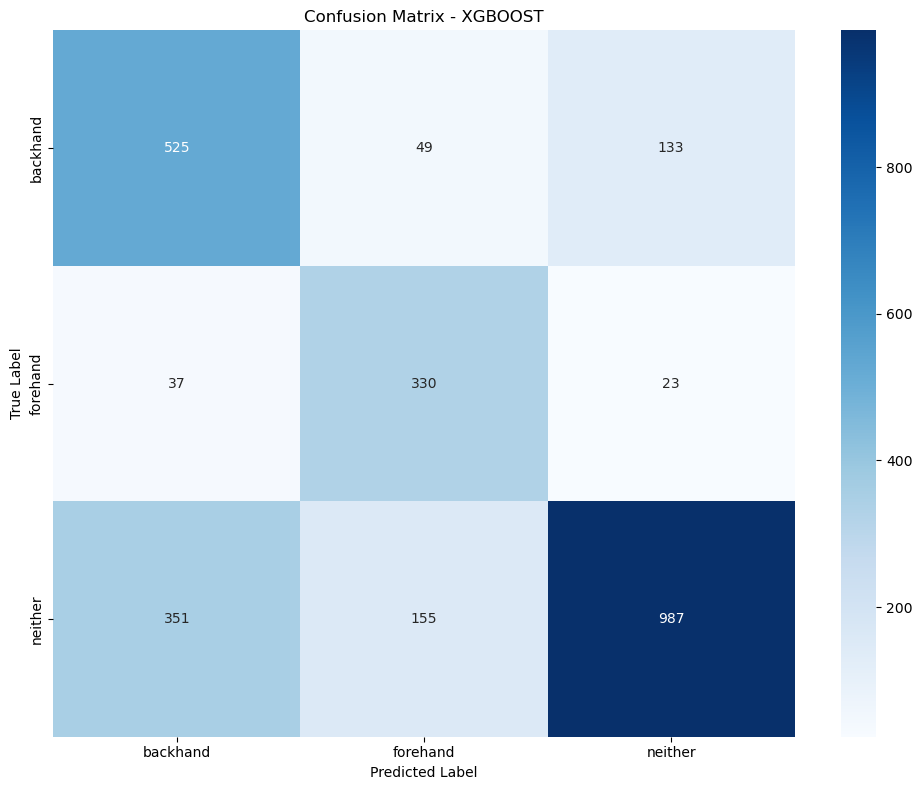

In [20]:
# ==================================================================================
# MAIN EXECUTION
# ==================================================================================

if __name__ == "__main__":
    trainer = StrokeDetectionTrainer()
    trainer.run_training_pipeline()